In [19]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample, hilbert, welch
import seaborn as sns
import mne
from mne.preprocessing import ICA
from scipy.stats import skew, kurtosis
import time

In [4]:
def bandpass_filter(data, lowcut, highcut, fs, order=4, axis=-1, verbose=True):
    """
    Apply a Butterworth bandpass filter.

    Parameters
    ----------
    data : np.ndarray
        EEG data array (time axis specified by `axis`).
    lowcut : float
        Lower cutoff frequency (Hz).
    highcut : float
        Upper cutoff frequency (Hz).
    fs : float
        Sampling frequency (Hz).
    order : int
        Filter order (default: 4).
    axis : int
        Axis representing time (default: last).
    verbose : bool
        If True, print filter details.

    Returns
    -------
    np.ndarray
        Filtered signal (same shape as input).
    """
    if highcut >= fs / 2:
        raise ValueError(f"Highcut frequency must be below Nyquist ({fs/2} Hz).")

    # Nyquist frequency
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # Design Butterworth bandpass
    b, a = butter(order, [low, high], btype='band')

    if verbose:
        print(f"Applying Bandpass Filter: {lowcut}–{highcut} Hz, Order={order}, Fs={fs} Hz")
        print(f"Data shape: {data.shape} | Filtering along axis {axis}")

    # Apply zero-phase filtering
    filtered_data = filtfilt(b, a, data, axis=axis)

    if verbose:
        print("Filtering complete. Output shape:", filtered_data.shape)

    return filtered_data

def downsample_eeg(data, original_fs, target_fs, axis=-1, verbose=True):
    """
    Downsamples EEG data along the specified axis (time).

    Parameters
    ----------
    data : np.ndarray
        EEG array (..., samples) with time along `axis`.
    original_fs : float
        Original sampling rate (e.g., 128).
    target_fs : float
        Target sampling rate (must be less than original_fs).
    axis : int
        Axis representing time (default: -1).
    verbose : bool
        If True, print duration, resampling, and shape details.

    Returns
    -------
    np.ndarray
        Downsampled EEG data (same shape except time axis length changes).
    """
    if target_fs >= original_fs:
        raise ValueError("Target sampling rate must be less than original rate.")

    original_shape = data.shape
    total_samples = data.shape[axis]
    total_duration = total_samples / original_fs

    # Calculate new number of samples
    n_samples = int(round(total_samples * target_fs / original_fs))

    # Perform resampling along the chosen axis
    downsampled_data = resample(data, n_samples, axis=axis)

    if verbose:
        print(f"Original shape: {original_shape}")
        print(f"Original: {total_samples} samples @ {original_fs} Hz ({total_duration:.2f} s)")
        print(f"Downsampled shape: {downsampled_data.shape}")
        print(f"Downsampled: {n_samples} samples @ {target_fs} Hz ({total_duration:.2f} s)")
        print(f"Compression ratio: {total_samples/n_samples:.2f}x")

    return downsampled_data

def select_time_segment(data, fs, start_sec, end_sec, axis=-1, verbose=True):
    """
    Select a segment of the signal based on start and end times.

    Parameters
    ----------
    data : np.ndarray
        EEG array with time on `axis` (e.g., trials×channels×samples or subjects×trials×channels×samples).
    fs : int or float
        Sampling rate in Hz.
    start_sec : float
        Start time in seconds (inclusive).
    end_sec : float
        End time in seconds (exclusive).
    axis : int
        Which axis is time (default: last).
    verbose : bool
        If True, print duration and shape details.

    Returns
    -------
    segment : np.ndarray
        Extracted segment of the same shape as input, except for the time axis length.
    """
    # Store original shape
    original_shape = data.shape

    # Get total duration
    total_samples = data.shape[axis]
    total_duration = total_samples / fs

    # Validate input times
    if start_sec < 0 or end_sec > total_duration:
        raise ValueError(f"Start ({start_sec}s) and End ({end_sec}s) must be within 0–{total_duration:.2f}s")
    if start_sec >= end_sec:
        raise ValueError("start_sec must be less than end_sec.")

    # Convert seconds to sample indices
    start_idx = int(round(start_sec * fs))
    end_idx = int(round(end_sec * fs))

    # Extract segment
    x = np.moveaxis(data, axis, -1)   # put time last
    segment = x[..., start_idx:end_idx]
    segment = np.moveaxis(segment, -1, axis)

    # Notification
    if verbose:
        seg_duration = (end_idx - start_idx) / fs
        print(f"Original shape: {original_shape}")
        print(f"Original duration: {total_duration:.2f} s ({total_samples} samples @ {fs} Hz)")
        print(f"Selected segment shape: {segment.shape}")
        print(f"Selected segment duration: {seg_duration:.2f} s ({end_idx - start_idx} samples)")
        print(f"From {start_sec:.2f} s to {end_sec:.2f} s")

    return segment

def common_average_reference(
    data,
    channel_axis=1,          # axis for channels
    exclude=None,            # list/array of channel indices to EXCLUDE from the average
    verbose=True
):
    """
    Apply Common Average Referencing (CAR): subtract the mean across channels
    (computed at each time point) from every channel.

    Parameters
    ----------
    data : np.ndarray
        EEG array with a dedicated channels axis, e.g. (trials, channels, samples)
        or (subjects, trials, channels, samples).
    channel_axis : int
        Axis index that corresponds to channels.
    exclude : list[int] or np.ndarray or None
        Channel indices to exclude when computing the average reference
        (e.g., very noisy/bad channels). The reference is computed from the
        remaining channels and subtracted from ALL channels.
    verbose : bool
        If True, print shape and details.

    Returns
    -------
    car_data : np.ndarray
        CAR-referenced data with the same shape as input.
    """
    x = np.asarray(data, dtype=np.float64)
    orig_shape = x.shape

    n_ch = x.shape[channel_axis]
    if n_ch < 2:
        raise ValueError("CAR requires at least 2 channels.")

    # Build slicers for selecting good channels
    if exclude is None or len(exclude) == 0:
        # mean across all channels at each time sample
        ref = x.mean(axis=channel_axis, keepdims=True)
        used_ch = n_ch
    else:
        exclude = np.array(exclude, dtype=int)
        all_idx = np.arange(n_ch)
        good_idx = np.setdiff1d(all_idx, exclude)
        if good_idx.size == 0:
            raise ValueError("All channels were excluded; need at least one channel to compute reference.")
        # take only good channels for computing the average
        ref = np.take(x, good_idx, axis=channel_axis).mean(axis=channel_axis, keepdims=True)
        used_ch = good_idx.size

    car_data = x - ref  # broadcast subtraction across channels

    if verbose:
        print(f"CAR applied on data shape {orig_shape}")
        print(f"Channels axis: {channel_axis} | Total channels: {n_ch} | Used for ref: {used_ch}")
        if exclude is not None and len(exclude) > 0:
            print(f"Excluded channels from reference: {exclude.tolist()}")

    return car_data

## Read Data

In [5]:
# Paths
root_path = 'DEAP'
data_folder = os.path.join(root_path, 'data_preprocessed_python')

# Containers
all_subjects_data = []   # list of (trials, channels, samples)
all_subjects_labels = [] # list of (trials, 4)  [valence, arousal, dominance, liking]
subject_ids = []         # optional: list of subject IDs (e.g., 's01', 's02', ...)

# Loop through all .dat files sorted by subject number
for fname in sorted(os.listdir(data_folder)):
    if fname.endswith('.dat') and fname.startswith('s'):
        fpath = os.path.join(data_folder, fname)
        with open(fpath, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
        eeg_data = data['data']    # shape (40, 40, 8064)
        labels = data['labels']    # shape (40, 4)
        
        all_subjects_data.append(eeg_data)
        all_subjects_labels.append(labels)
        subject_ids.append(fname[:-4])  # 's01' without '.dat'
        
        print(f"Loaded {fname}: EEG {eeg_data.shape}, labels {labels.shape}")

# Convert lists to numpy arrays if needed
# Shape would be (subjects, trials, channels, samples)
all_subjects_data = np.array(all_subjects_data, dtype=np.float32)
all_subjects_labels = np.array(all_subjects_labels, dtype=np.float32)

print("\nFinal shapes:")
print("EEG data:", all_subjects_data.shape)     # (n_subjects, 40, 40, 8064)
print("Labels:", all_subjects_labels.shape)     # (n_subjects, 40, 4)
print("Subjects:", subject_ids)

Loaded s01.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s02.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s03.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s04.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s05.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s06.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s07.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s08.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s09.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s10.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s11.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s12.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s13.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s14.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s15.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s16.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s17.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s18.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s19.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s20.dat: EEG (40, 40, 80

## Preprocessing

In [6]:
fs = 128
target_fs = 128
lowcut = 1.0   # lower bound
highcut = 45.0 # upper bound

data = all_subjects_data[:, :, :32, :]
data = bandpass_filter(data, lowcut, highcut, fs)
data = common_average_reference(data)
# data = downsample_eeg(data, fs, target_fs)
data = select_time_segment(data, fs, start_sec=3, end_sec=63)

Applying Bandpass Filter: 1.0–45.0 Hz, Order=4, Fs=128 Hz
Data shape: (32, 40, 32, 8064) | Filtering along axis -1
Filtering complete. Output shape: (32, 40, 32, 8064)
CAR applied on data shape (32, 40, 32, 8064)
Channels axis: 1 | Total channels: 40 | Used for ref: 40
Original shape: (32, 40, 32, 8064)
Original duration: 63.00 s (8064 samples @ 128 Hz)
Selected segment shape: (32, 40, 32, 7680)
Selected segment duration: 60.00 s (7680 samples)
From 3.00 s to 63.00 s


In [7]:
# =====================================================
# Time-domain Features
# =====================================================

def extract_mean_feature(X):
    """
    Compute mean value of the signal.

    Parameters:
        X : ndarray, shape (..., N)
            EEG time series (last axis = samples).

    Returns:
        mean_val : ndarray, shape (...)
            Mean value of the signal.
    """
    return np.mean(X, axis=-1)


def extract_mean_absolute_value(X):
    """
    Compute mean absolute value (average magnitude).

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        mav : ndarray, shape (...)
            Mean absolute value.
    """
    return np.mean(np.abs(X), axis=-1)


def extract_min_feature(X):
    """
    Find the minimum amplitude.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        min_val : ndarray, shape (...)
            Minimum value of the signal.
    """
    return np.min(X, axis=-1)


def extract_max_feature(X):
    """
    Find the maximum amplitude.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        max_val : ndarray, shape (...)
            Maximum value of the signal.
    """
    return np.max(X, axis=-1)


def extract_range_feature(X):
    """
    Compute the range (max - min).

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        range_val : ndarray, shape (...)
            Signal amplitude range.
    """
    return np.max(X, axis=-1) - np.min(X, axis=-1)


def extract_std_feature(X):
    """
    Compute standard deviation.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        std_val : ndarray, shape (...)
            Standard deviation (ddof=1).
    """
    return np.std(X, axis=-1, ddof=1)


def extract_variance_feature(X):
    """
    Compute variance.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        var_val : ndarray, shape (...)
            Variance (ddof=1).
    """
    return np.var(X, axis=-1, ddof=1)


def extract_median_feature(X):
    """
    Compute median value.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        median_val : ndarray, shape (...)
            Median of the signal.
    """
    return np.median(X, axis=-1)


# =====================================================
# Signal Difference Features
# =====================================================

def extract_mean_abs_first_diff(X):
    """
    Compute mean absolute first-order difference.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        mad1 : ndarray, shape (...)
            Mean absolute first difference.
    """
    diff = np.diff(X, axis=-1)
    return np.mean(np.abs(diff), axis=-1)


def extract_mean_abs_second_diff(X):
    """
    Compute mean absolute second-order difference.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        mad2 : ndarray, shape (...)
            Mean absolute second difference.
    """
    diff2 = np.diff(X, n=2, axis=-1)
    return np.mean(np.abs(diff2), axis=-1)


# =====================================================
# Distribution Shape Features
# =====================================================

def extract_skewness_feature(X):
    """
    Compute skewness of amplitude distribution.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        skewness : ndarray, shape (...)
            Measure of asymmetry.
    """
    return skew(X, axis=-1, bias=False)


def extract_kurtosis_feature(X):
    """
    Compute kurtosis of amplitude distribution.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        kurtosis_val : ndarray, shape (...)
            Peakedness/flatness (0 = Gaussian).
    """
    return kurtosis(X, axis=-1, fisher=True, bias=False)


# =====================================================
# Crossing & Amplitude Features
# =====================================================

def extract_zero_crossing_rate(X):
    """
    Compute zero-crossing rate (ZCR).

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        zcr : ndarray, shape (...)
            Proportion of sign changes.
    """
    signs = np.sign(X)
    crossings = (signs[..., :-1] * signs[..., 1:]) < 0
    return crossings.sum(axis=-1) / (X.shape[-1] - 1)


def extract_peak_amplitude(X):
    """
    Compute maximum absolute amplitude.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        peak_amp : ndarray, shape (...)
            Peak amplitude.
    """
    return np.max(np.abs(X), axis=-1)


# =====================================================
# Energy & Power Features
# =====================================================

def extract_signal_energy(X):
    """
    Compute total energy (sum of squares).

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        energy : ndarray, shape (...)
            Signal energy.
    """
    return np.sum(X ** 2, axis=-1)


def extract_average_power(X):
    """
    Compute mean power (squared amplitudes).

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        power : ndarray, shape (...)
            Mean power.
    """
    return np.mean(X ** 2, axis=-1)


def extract_rms_feature(X):
    """
    Compute root mean square (RMS).

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        rms : ndarray, shape (...)
            RMS amplitude.
    """
    return np.sqrt(np.mean(X ** 2, axis=-1))


# =====================================================
# Temporal Slope Features
# =====================================================

def extract_slope_sign_change(X):
    """
    Count slope sign changes.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        ssc : ndarray, shape (...)
            Number of slope reversals.
    """
    diff1 = X[..., 1:-1] - X[..., :-2]
    diff2 = X[..., 1:-1] - X[..., 2:]
    return ((diff1 * diff2) > 0).sum(axis=-1)


def extract_willison_amplitude(X, threshold=0.01):
    """
    Count Willison amplitude crossings.

    Parameters:
        X : ndarray, shape (..., N)
        threshold : float
            Amplitude difference threshold.

    Returns:
        wa : ndarray, shape (...)
            Number of suprathreshold differences.
    """
    diff = np.abs(np.diff(X, axis=-1))
    return (diff > threshold).sum(axis=-1)


# =====================================================
# Wave Features
# =====================================================

def extract_number_of_waves(X, fs=128, return_rate=False):
    """
    Estimate number of waves using zero-crossings.

    Parameters:
        X : ndarray, shape (..., N)
        fs : float
            Sampling rate.
        return_rate : bool
            If True, return wave rate (Hz).

    Returns:
        n_waves : ndarray, shape (...)
            Number or rate of waves.
    """
    signs = np.sign(X)
    crossings = (signs[..., :-1] * signs[..., 1:]) < 0
    n_crossings = crossings.sum(axis=-1)
    n_waves = n_crossings // 2
    if return_rate:
        return n_waves / (X.shape[-1] / fs)
    return n_waves


def extract_wave_duration(X, fs=128):
    """
    Estimate mean wave duration.

    Parameters:
        X : ndarray, shape (..., N)
        fs : float
            Sampling rate.

    Returns:
        duration : ndarray, shape (...)
            Mean wave duration (s).
    """
    n_waves = extract_number_of_waves(X, fs)
    total_dur = X.shape[-1] / fs
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(n_waves > 0, total_dur / n_waves, np.nan)


# =====================================================
# Frequency Features
# =====================================================

def extract_mean_instantaneous_frequency(X, fs=128):
    """
    Compute mean instantaneous frequency via Hilbert transform.

    Parameters:
        X : ndarray, shape (..., N)
        fs : float
            Sampling rate.

    Returns:
        mif : ndarray, shape (...)
            Mean instantaneous frequency.
    """
    analytic = hilbert(X, axis=-1)
    phase = np.unwrap(np.angle(analytic), axis=-1)
    inst_freq = np.diff(phase, axis=-1) * (fs / (2*np.pi))
    return np.mean(inst_freq, axis=-1)


# =====================================================
# Hjorth Parameters
# =====================================================

def extract_hjorth_parameters(X):
    """
    Compute Hjorth parameters.

    Parameters:
        X : ndarray, shape (..., N)

    Returns:
        activity : ndarray, shape (...)
            Variance of the signal.
        mobility : ndarray, shape (...)
            sqrt(var(diff)/var(signal)).
        complexity : ndarray, shape (...)
            Ratio of mobilities (ddx/dx).
    """
    dx = np.diff(X, axis=-1)
    ddx = np.diff(dx, axis=-1)
    var0 = np.var(X, axis=-1, ddof=1)
    var1 = np.var(dx, axis=-1, ddof=1)
    var2 = np.var(ddx, axis=-1, ddof=1)
    activity = var0
    mobility = np.sqrt(var1 / (var0 + 1e-12))
    complexity = np.sqrt((var2 / (var1 + 1e-12)) / (var1 / (var0 + 1e-12) + 1e-12))
    return activity, mobility, complexity


# =====================================================
# Entropy & Complexity
# =====================================================

def compute_sample_entropy(X, m=2, r=0.2):
    """
    Compute Sample Entropy (SampEn).

    Parameters:
        X : ndarray, shape (..., N)
            EEG signals.
        m : int
            Embedding dimension.
        r : float
            Tolerance (fraction of std).

    Returns:
        sampen : ndarray, shape (...)
            Sample entropy.
    """
    X = np.atleast_2d(X)
    N = X.shape[-1]
    std = np.std(X, axis=-1, keepdims=True)
    tol = r * std

    def _phi(m):
        subseq = np.lib.stride_tricks.sliding_window_view(X, m, axis=-1)
        dist = np.max(np.abs(subseq[:, :, None, :] - subseq[:, None, :, :]), axis=-1)
        matches = np.sum(dist <= tol[..., None], axis=-1) - 1
        return np.sum(matches, axis=-1)

    B = _phi(m)
    A = _phi(m+1)
    return -np.log((A+1e-12) / (B+1e-12)).squeeze()


def compute_permutation_entropy(X, m=3, tau=1):
    """
    Compute Permutation Entropy (PE).

    Parameters:
        X : ndarray, shape (..., N)
        m : int
            Embedding dimension.
        tau : int
            Time delay.

    Returns:
        pe : ndarray, shape (...)
            Permutation entropy.
    """
    X = np.atleast_2d(X)
    N = X.shape[-1]
    pe = np.zeros(X.shape[:-1])
    for idx in np.ndindex(X.shape[:-1]):
        ts = X[idx]
        n_patterns = N - (m-1)*tau
        if n_patterns <= 0:
            pe[idx] = np.nan
            continue
        patterns = np.array([ts[j*tau:j*tau+n_patterns] for j in range(m)]).T
        ranks = np.argsort(np.argsort(patterns, axis=1), axis=1)
        _, counts = np.unique(ranks, axis=0, return_counts=True)
        probs = counts / counts.sum()
        pe[idx] = -np.sum(probs * np.log2(probs+1e-12))
    return pe.squeeze()


def compute_higuchi_fd(X, kmax=10):
    """
    Compute Higuchi Fractal Dimension.

    Parameters:
        X : ndarray, shape (..., N)
        kmax : int
            Maximum interval.

    Returns:
        fd : ndarray, shape (...)
            Fractal dimension.
    """
    X = np.atleast_2d(X)
    N = X.shape[-1]
    fd = np.zeros(X.shape[:-1])
    for idx in np.ndindex(X.shape[:-1]):
        ts = X[idx]
        L, k_vals = [], np.arange(1, kmax+1)
        for k in k_vals:
            Lk = []
            for m in range(k):
                idxs = np.arange(m, N, k)
                if len(idxs) < 2: continue
                Lm = np.sum(np.abs(np.diff(ts[idxs]))) * (N-1)/(len(idxs)*k)
                Lk.append(Lm)
            if Lk: L.append(np.mean(Lk))
        coeffs = np.polyfit(np.log(k_vals[:len(L)]), np.log(L), 1)
        fd[idx] = -coeffs[0]
    return fd.squeeze()

# =====================================================
# PSD Computation (Welch's Method)
# =====================================================

def compute_welch_psd(eeg_data, fs=128, nperseg=None, noverlap=None, window='hann', scaling='density'):
    """
    Compute Power Spectral Density (PSD) using Welch's method.

    Parameters:
        eeg_data : ndarray, shape (S, T, C, N)
            EEG signals (subjects × trials × channels × samples).
        fs : float
            Sampling frequency (Hz).
        nperseg : int or None
            Segment length (samples). Default = 2*fs.
        noverlap : int or None
            Overlap between segments. Default = nperseg//2.
        window : str
            Window type for Welch (default: 'hann').
        scaling : str
            'density' (V²/Hz) or 'spectrum' (V²).

    Returns:
        freqs : ndarray, shape (F,)
            Frequency bins.
        psd : ndarray, shape (S, T, C, F)
            PSD values per subject, trial, channel.
    """
    S, T, C, N = eeg_data.shape
    if nperseg is None:
        nperseg = int(2 * fs)
    if noverlap is None:
        noverlap = nperseg // 2

    psd_list, freqs = [], None
    for s in range(S):
        trial_list = []
        for t in range(T):
            ch_list = []
            for c in range(C):
                f, Pxx = welch(eeg_data[s, t, c], fs=fs, nperseg=nperseg,
                               noverlap=noverlap, window=window, scaling=scaling)
                if freqs is None:
                    freqs = f
                ch_list.append(Pxx)
            trial_list.append(np.array(ch_list))
        psd_list.append(np.array(trial_list))
    return freqs, np.array(psd_list)


# =====================================================
# Absolute & Relative Band Powers
# =====================================================

def extract_absolute_band_powers(freqs, psd):
    """
    Compute absolute band powers (integrated PSD per band).

    Parameters:
        freqs : ndarray, shape (F,)
            Frequency bins.
        psd : ndarray, shape (S, T, C, F)
            PSD values.

    Returns:
        band_powers : ndarray, shape (S, T, C, B)
            Absolute power in each band.
        band_names : list[str]
            Names of bands.
    """
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "sigma": (12, 14),
        "beta":  (12, 30),
        "gamma": (30, 45)
    }
    band_names = list(bands.keys())
    band_powers = np.zeros(psd.shape[:-1] + (len(bands),))
    for i, (band, (lo, hi)) in enumerate(bands.items()):
        mask = (freqs >= lo) & (freqs <= hi)
        band_powers[..., i] = np.trapezoid(psd[..., mask], freqs[mask], axis=-1)
    return band_powers, band_names


def extract_relative_band_powers(freqs, psd):
    """
    Compute relative band powers (normalized by total PSD power).

    Parameters:
        freqs : ndarray, shape (F,)
        psd : ndarray, shape (S, T, C, F)

    Returns:
        rel_powers : ndarray, shape (S, T, C, B)
            Relative power fraction per band.
        band_names : list[str]
    """
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "sigma": (12, 14),
        "beta":  (12, 30),
        "gamma": (30, 45)
    }
    band_names = list(bands.keys())
    rel_powers = np.zeros(psd.shape[:-1] + (len(bands),))

    total_power = np.trapezoid(psd, freqs, axis=-1)[..., None]
    for i, (band, (lo, hi)) in enumerate(bands.items()):
        mask = (freqs >= lo) & (freqs <= hi)
        band_power = np.trapezoid(psd[..., mask], freqs[mask], axis=-1)
        rel_powers[..., i] = band_power / (total_power[..., 0] + 1e-12)
    return rel_powers, band_names


# =====================================================
# Band Ratios
# =====================================================

def compute_band_ratios(band_powers, band_names):
    """
    Compute EEG band ratios (e.g., theta/alpha).

    Parameters:
        band_powers : ndarray, shape (S, T, C, B)
        band_names : list[str]

    Returns:
        ratios : dict[str, ndarray]
            Dictionary of ratio arrays (S, T, C).
    """
    idx = {b: i for i, b in enumerate(band_names)}
    ratios = {}
    if "theta" in idx and "alpha" in idx:
        ratios["theta_alpha"] = band_powers[..., idx["theta"]] / (band_powers[..., idx["alpha"]] + 1e-12)
    if "beta" in idx and "alpha" in idx:
        ratios["beta_alpha"] = band_powers[..., idx["beta"]] / (band_powers[..., idx["alpha"]] + 1e-12)
    if "theta" in idx and "beta" in idx:
        ratios["theta_beta"] = band_powers[..., idx["theta"]] / (band_powers[..., idx["beta"]] + 1e-12)
    if all(b in idx for b in ["theta", "alpha", "beta"]):
        ratios["(theta+alpha)_beta"] = (band_powers[..., idx["theta"]] + band_powers[..., idx["alpha"]]) / \
                                      (band_powers[..., idx["beta"]] + 1e-12)
    if "delta" in idx and "alpha" in idx:
        ratios["delta_alpha"] = band_powers[..., idx["delta"]] / (band_powers[..., idx["alpha"]] + 1e-12)
    if "delta" in idx and "theta" in idx:
        ratios["delta_theta"] = band_powers[..., idx["delta"]] / (band_powers[..., idx["theta"]] + 1e-12)
    if all(b in idx for b in ["delta", "theta", "alpha", "beta"]):
        ratios["(delta+theta)_(alpha+beta)"] = \
            (band_powers[..., idx["delta"]] + band_powers[..., idx["theta"]]) / \
            (band_powers[..., idx["alpha"]] + band_powers[..., idx["beta"]] + 1e-12)
    if "gamma" in idx and "delta" in idx:
        ratios["gamma_delta"] = band_powers[..., idx["gamma"]] / (band_powers[..., idx["delta"]] + 1e-12)
    return ratios


# =====================================================
# Peak Frequencies
# =====================================================

def compute_peak_frequencies(freqs, psd, bands=None):
    """
    Find peak frequency within each band.

    Parameters:
        freqs : ndarray, shape (F,)
        psd : ndarray, shape (S, T, C, F)
        bands : dict or None
            Defaults to standard EEG bands.

    Returns:
        peak_freqs : ndarray, shape (S, T, C, B)
        band_names : list[str]
    """
    if bands is None:
        bands = {
            "delta": (0.5, 4),
            "theta": (4, 8),
            "alpha": (8, 12),
            "sigma": (12, 14),
            "beta":  (12, 30),
            "gamma": (30, 45)
        }
    band_names = list(bands.keys())
    peak_freqs = np.zeros(psd.shape[:-1] + (len(bands),))
    for i, (band, (lo, hi)) in enumerate(bands.items()):
        mask = (freqs >= lo) & (freqs <= hi)
        band_psd, band_freqs = psd[..., mask], freqs[mask]
        peak_idx = np.argmax(band_psd, axis=-1)
        peak_freqs[..., i] = band_freqs[peak_idx]
    return peak_freqs, band_names


# =====================================================
# PSD Statistics
# =====================================================

def compute_psd_statistics(psd):
    """
    Compute descriptive statistics of PSD.

    Parameters:
        psd : ndarray, shape (S, T, C, F)

    Returns:
        stats : dict[str, ndarray]
            Mean, median, variance, std, skew, kurtosis.
    """
    return {
        "psd_mean": np.mean(psd, axis=-1),
        "psd_median": np.median(psd, axis=-1),
        "psd_variance": np.var(psd, axis=-1, ddof=1),
        "psd_std": np.std(psd, axis=-1, ddof=1),
        "psd_skewness": skew(psd, axis=-1, bias=False),
        "psd_kurtosis": kurtosis(psd, axis=-1, fisher=True, bias=False),
    }


# =====================================================
# Spectral Entropy
# =====================================================

def compute_spectral_entropy(freqs, psd):
    """
    Compute Shannon entropy of normalized PSD.

    Parameters:
        freqs : ndarray, shape (F,)
        psd : ndarray, shape (S, T, C, F)

    Returns:
        entropy : ndarray, shape (S, T, C)
    """
    psd_norm = psd / (np.sum(psd, axis=-1, keepdims=True) + 1e-12)
    return -np.sum(psd_norm * np.log2(psd_norm + 1e-12), axis=-1)


# =====================================================
# Spectral Edge Frequency (SEF)
# =====================================================

def compute_spectral_edge_frequency(freqs, psd, edge=0.95):
    """
    Compute spectral edge frequency (SEF).

    Parameters:
        freqs : ndarray, shape (F,)
        psd : ndarray, shape (S, T, C, F)
        edge : float
            Fraction of total power (default 0.95).

    Returns:
        sef : ndarray, shape (S, T, C)
    """
    cumsum_power = np.cumsum(psd, axis=-1)
    cumsum_norm = cumsum_power / (cumsum_power[..., -1][..., None] + 1e-12)
    idx_edge = np.argmax(cumsum_norm >= edge, axis=-1)
    return freqs[idx_edge]


# =====================================================
# Spectral Centroid
# =====================================================

def compute_spectral_centroid(freqs, psd):
    """
    Compute spectral centroid (center of gravity).

    Parameters:
        freqs : ndarray, shape (F,)
        psd : ndarray, shape (S, T, C, F)

    Returns:
        centroid : ndarray, shape (S, T, C)
    """
    weighted_sum = np.sum(freqs * psd, axis=-1)
    return weighted_sum / (np.sum(psd, axis=-1) + 1e-12)


# =====================================================
# Spectral Slope (1/f Exponent)
# =====================================================

def compute_spectral_slope(freqs, psd, fmin=1, fmax=45):
    """
    Compute spectral slope (1/f exponent).

    Parameters:
        freqs : ndarray, shape (F,)
        psd : ndarray, shape (S, T, C, F)
        fmin, fmax : float
            Frequency range for fit.

    Returns:
        slope : ndarray, shape (S, T, C)
        intercept : ndarray, shape (S, T, C)
    """
    mask = (freqs >= fmin) & (freqs <= fmax)
    log_freqs = np.log10(freqs[mask])
    log_psd = np.log10(psd[..., mask] + 1e-12)

    S, T, C, _ = log_psd.shape
    slope, intercept = np.zeros((S, T, C)), np.zeros((S, T, C))
    for s in range(S):
        for t in range(T):
            for c in range(C):
                coeffs = np.polyfit(log_freqs, log_psd[s, t, c], 1)
                slope[s, t, c], intercept[s, t, c] = coeffs
    return slope, intercept

# =====================================================
# Symmetry / Asymmetry Features
# =====================================================

def compute_power_asymmetry(band_powers, band_names, left_chs, right_chs):
    """
    Compute hemispheric power asymmetry indices.

    Parameters:
        band_powers : ndarray, shape (S, T, C, B)
            Absolute or relative band powers.
        band_names : list[str]
            Names of bands.
        left_chs : list[int]
            Indices of left-hemisphere channels (e.g., [0,1,2,3,...]).
        right_chs : list[int]
            Indices of right-hemisphere channels (same size as left_chs).

    Returns:
        asymmetry : dict[str, ndarray], each (S, T, B, P)
            Asymmetry indices for each pair and band:
            AI = (Left - Right) / (Left + Right).
            P = number of pairs.

    Notes:
        - Positive AI: more power on left.
        - Negative AI: more power on right.
    """
    if len(left_chs) != len(right_chs):
        raise ValueError("Left and right channel lists must have the same length.")

    asymmetry = {}
    n_pairs = len(left_chs)

    for b, band in enumerate(band_names):
        ai_vals = []
        for l, r in zip(left_chs, right_chs):
            L = band_powers[..., l, b]
            R = band_powers[..., r, b]
            AI = (L - R) / (L + R + 1e-12)
            ai_vals.append(AI)
        asymmetry[band] = np.stack(ai_vals, axis=-1)  # shape (S, T, P)
    return asymmetry


def compute_frontal_asymmetry(band_powers, band_names, left_ch, right_ch, band="alpha"):
    """
    Compute simple frontal asymmetry index for a single pair.

    Parameters:
        band_powers : ndarray, shape (S, T, C, B)
        band_names : list[str]
        left_ch : int
            Left channel index (e.g., F3).
        right_ch : int
            Right channel index (e.g., F4).
        band : str
            Band name (e.g., 'alpha').

    Returns:
        fa : ndarray, shape (S, T)
            Frontal asymmetry index: (L - R) / (L + R).
    """
    b = band_names.index(band)
    L = band_powers[..., left_ch, b]
    R = band_powers[..., right_ch, b]
    return (L - R) / (L + R + 1e-12)

In [11]:
def extract_all_features_batch(eeg_data, all_subjects_labels, fs=128, left_chs=None, right_chs=None, verbose=True):
    """
    Extract a full set of EEG features in batch with progress logging, 
    and attach emotion labels (valence, arousal, dominance, liking).

    Parameters
    ----------
    eeg_data : ndarray, shape (S, T, C, N)
        EEG data (subjects × trials × channels × samples).
    all_subjects_labels : ndarray, shape (S, T, 4)
        Labels: valence, arousal, dominance, liking
    fs : int
        Sampling frequency.
    left_chs, right_chs : list[int] or None
        Channel indices for asymmetry features.
    verbose : bool
        If True, display progress and timing.

    Returns
    -------
    df : pandas.DataFrame
        Flattened dataframe with all features and labels (rows = S×T×C).
    """

    S, T, C, N = eeg_data.shape
    n_rows = S * T * C
    rows = []

    def log_step(step_name, start_time):
        if verbose:
            elapsed = time.time() - start_time
            print(f"{step_name} done in {elapsed:.2f} sec")

    # ------------------------
    # PSD computation
    # ------------------------
    if verbose: print("[Step 1/6] Computing PSD (Welch)...")
    t0 = time.time()
    freqs, psd = compute_welch_psd(eeg_data, fs=fs)
    log_step("PSD (Welch)", t0)

    # ------------------------
    # Band powers
    # ------------------------
    if verbose: print("[Step 2/6] Extracting absolute/relative band powers...")
    t0 = time.time()
    abs_powers, band_names = extract_absolute_band_powers(freqs, psd)
    rel_powers, _ = extract_relative_band_powers(freqs, psd)
    log_step("Band powers", t0)

    # ------------------------
    # Time-domain features
    # ------------------------
    if verbose: print("[Step 3/6] Extracting time-domain features...")
    t0 = time.time()
    feat_mean = extract_mean_feature(eeg_data)
    feat_rms = extract_rms_feature(eeg_data)
    feat_std = extract_std_feature(eeg_data)
    feat_var = extract_variance_feature(eeg_data)
    feat_skew = extract_skewness_feature(eeg_data)
    feat_kurt = extract_kurtosis_feature(eeg_data)
    hj_act, hj_mob, hj_compl = extract_hjorth_parameters(eeg_data)
    log_step("Time-domain features", t0)

    # ------------------------
    # Entropy & complexity
    # ------------------------
    if verbose: print("[Step 4/6] Extracting entropy/complexity features...")
    t0 = time.time()
    feat_permEn = compute_permutation_entropy(eeg_data)
    feat_fd = compute_higuchi_fd(eeg_data)
    spec_entropy = compute_spectral_entropy(freqs, psd)
    log_step("Entropy/complexity", t0)

    # ------------------------
    # Spectral features
    # ------------------------
    if verbose: print("[Step 5/6] Extracting spectral features...")
    t0 = time.time()
    band_ratios = compute_band_ratios(rel_powers, band_names)
    peak_freqs, _ = compute_peak_frequencies(freqs, psd, bands=None)
    psd_stats = compute_psd_statistics(psd)
    sef = compute_spectral_edge_frequency(freqs, psd)
    centroid = compute_spectral_centroid(freqs, psd)
    slope, intercept = compute_spectral_slope(freqs, psd)
    log_step("Spectral features", t0)

    # ------------------------
    # Symmetry features
    # ------------------------
    asymmetry = None
    if left_chs is not None and right_chs is not None:
        if verbose: print("[Step 6/6] Extracting symmetry/asymmetry features...")
        t0 = time.time()
        asymmetry = compute_power_asymmetry(abs_powers, band_names, left_chs, right_chs)
        log_step("Symmetry/asymmetry", t0)

    # ------------------------
    # Flatten into dataframe
    # ------------------------
    if verbose: print("Compiling features into DataFrame...")
    t0 = time.time()

    for s in range(S):
        for t in range(T):
            # grab labels for this subject+trial
            valence, arousal, dominance, liking = all_subjects_labels[s, t]

            for c in range(C):
                row = {
                    "subject": s,
                    "trial": t,
                    "channel": c,
                    "valence": valence,
                    "arousal": arousal,
                    "dominance": dominance,
                    "liking": liking,
                    "mean": feat_mean[s,t,c],
                    "rms": feat_rms[s,t,c],
                    "std": feat_std[s,t,c],
                    "var": feat_var[s,t,c],
                    "skew": feat_skew[s,t,c],
                    "kurtosis": feat_kurt[s,t,c],
                    "hj_activity": hj_act[s,t,c],
                    "hj_mobility": hj_mob[s,t,c],
                    "hj_complexity": hj_compl[s,t,c],
                    "perm_entropy": feat_permEn[s,t,c],
                    "higuchi_fd": feat_fd[s,t,c],
                    "spec_entropy": spec_entropy[s,t,c],
                    "sef95": sef[s,t,c],
                    "spec_centroid": centroid[s,t,c],
                    "spec_slope": slope[s,t,c],
                }
                for b_i, b in enumerate(band_names):
                    row[f"abs_{b}"] = abs_powers[s,t,c,b_i]
                    row[f"rel_{b}"] = rel_powers[s,t,c,b_i]
                    row[f"peak_{b}"] = peak_freqs[s,t,c,b_i]
                for k,v in band_ratios.items():
                    row[f"ratio_{k}"] = v[s,t,c]
                for k,v in psd_stats.items():
                    row[k] = v[s,t,c]
                if asymmetry is not None:
                    for b, arr in asymmetry.items():
                        for p in range(arr.shape[-1]):
                            row[f"AI_{b}_pair{p}"] = arr[s,t,p]
                rows.append(row)

    df = pd.DataFrame(rows)
    log_step("DataFrame compilation", t0)

    if verbose: print(f"Extracted {df.shape[1]} features for {df.shape[0]} rows.")

    return df

## Feature Extraction

In [35]:
#df = extract_all_features_batch(data, all_subjects_labels, fs=fs)

In [45]:
#df.to_csv("eeg_features.csv", index=False)

In [13]:
df = pd.read_csv('eeg_features.csv')

In [14]:
df["valence_binary"] = np.where(df["valence"] >= 5, "high", "low")
df["arousal_binary"] = np.where(df["arousal"] >= 5, "high", "low")
df["dominance_binary"] = np.where(df["dominance"] >= 5, "high", "low")

In [15]:
channel_names = [
    "Fp1","AF3","F3","F7","FC5","FC1","C3","T7","CP5","CP1","P3","P7","PO3","O1","Oz","Pz",
    "Fp2","AF4","Fz","F4","F8","FC6","FC2","Cz","C4","T8","CP6","CP2","P4","P8","PO4","O2"
]

channel_regions = {
    "Fp1": "frontal", "AF3": "frontal", "F3": "frontal", "F7": "frontal",
    "FC5": "frontal", "FC1": "frontal", "Fz": "frontal", "F4": "frontal", "F8": "frontal",
    "FC6": "frontal", "FC2": "frontal", "AF4": "frontal",

    "C3": "central", "Cz": "central", "C4": "central",

    "T7": "temporal", "T8": "temporal",

    "CP5": "parietal", "CP1": "parietal", "P3": "parietal", "P7": "parietal", 
    "Pz": "parietal", "CP6": "parietal", "CP2": "parietal", "P4": "parietal", "P8": "parietal",

    "PO3": "occipital", "O1": "occipital", "Oz": "occipital", 
    "PO4": "occipital", "O2": "occipital"
}

In [16]:
print(df["valence_binary"].value_counts())
print(df["arousal_binary"].value_counts())

valence_binary
high    23168
low     17792
Name: count, dtype: int64
arousal_binary
high    24128
low     16832
Name: count, dtype: int64


In [17]:
# Map channel index → channel name
df["channel_name"] = df["channel"].map(lambda i: channel_names[i])

# Map channel name → brain region
df["region"] = df["channel_name"].map(channel_regions)

In [18]:
df

,subject,trial,channel,valence,arousal,dominance,liking,mean,rms,std,...,psd_median,psd_variance,psd_std,psd_skewness,psd_kurtosis,valence_binary,arousal_binary,dominance_binary,channel_name,region
0,0,0,0,7.71,7.60,6.9,7.83,0.003887,3.852120,3.852368,...,0.049824,0.126448,0.355595,1.757111,2.292328,high,high,high,Fp1,frontal
1,0,0,1,7.71,7.60,6.9,7.83,0.004956,4.185506,4.185776,...,0.042838,0.188190,0.433809,1.964357,3.644608,high,high,high,AF3,frontal
2,0,0,2,7.71,7.60,6.9,7.83,0.007343,4.422109,4.422391,...,0.057325,0.236338,0.486146,2.038177,4.155716,high,high,high,F3,frontal
3,0,0,3,7.71,7.60,6.9,7.83,0.001405,4.309631,4.309912,...,0.061318,0.263988,0.513798,2.368523,5.607894,high,high,high,F7,frontal
4,0,0,4,7.71,7.60,6.9,7.83,0.000517,3.161315,3.161521,...,0.039241,0.068435,0.261602,2.231184,4.560721,high,high,high,FC5,frontal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40955,31,39,27,7.15,4.03,9.0,1.88,0.042102,20.689377,20.690681,...,0.764934,693.170581,26.328133,5.317454,30.198737,high,low,high,CP2,parietal
40956,31,39,28,7.15,4.03,9.0,1.88,0.011301,12.451913,12.452718,...,0.358202,84.730498,9.204917,5.342135,30.860593,high,low,high,P4,parietal
40957,31,39,29,7.15,4.03,9.0,1.88,-0.009076,11.580358,11.581108,...,0.395472,54.182105,7.360849,5.249700,29.616150,high,low,high,P8,parietal
40958,31,39,30,7.15,4.03,9.0,1.88,0.083114,35.109424,35.111611,...,2.199439,5594.288012,74.794973,5.245785,29.354667,high,low,high,PO4,occipital


In [20]:
def plot_features_valence_arousal(df, feature_cols, row_wrap=3, palette="Set2"):
    """
    Visualize feature distributions by both Valence and Arousal labels.

    Parameters
    ----------
    df : DataFrame
        Input dataframe with features, regions, and labels.
    feature_cols : list of str
        List of feature column names to plot.
    row_wrap : int
        Number of columns per row for subplots.
    palette : str
        Seaborn palette.
    """
    # Melt for Valence
    df_val = df.melt(
        id_vars=["valence_binary", "region"],
        value_vars=feature_cols,
        var_name="feature",
        value_name="value"
    )
    df_val = df_val.rename(columns={"valence_binary": "label"})
    df_val["label_type"] = "Valence"

    # Melt for Arousal
    df_arousal = df.melt(
        id_vars=["arousal_binary", "region"],
        value_vars=feature_cols,
        var_name="feature",
        value_name="value"
    )
    df_arousal = df_arousal.rename(columns={"arousal_binary": "label"})
    df_arousal["label_type"] = "Arousal"

    # Combine both
    df_long = pd.concat([df_val, df_arousal], axis=0, ignore_index=True)

    # Plot
    g = sns.catplot(
        data=df_long, kind="box",
        x="label", y="value",
        hue="region",
        col="feature", row="label_type",   # facet by feature (col) and label type (row)
        palette=palette, sharey=False,
        height=4, aspect=1.2
    )

    g.set_titles("{col_name} | {row_name}")
    g.set_axis_labels("Label (0=Low, 1=High)", "Value")
    g._legend.set_title("Region")
    g.fig.suptitle("Feature Differences by Valence & Arousal across Regions", y=1.02)
    plt.show()

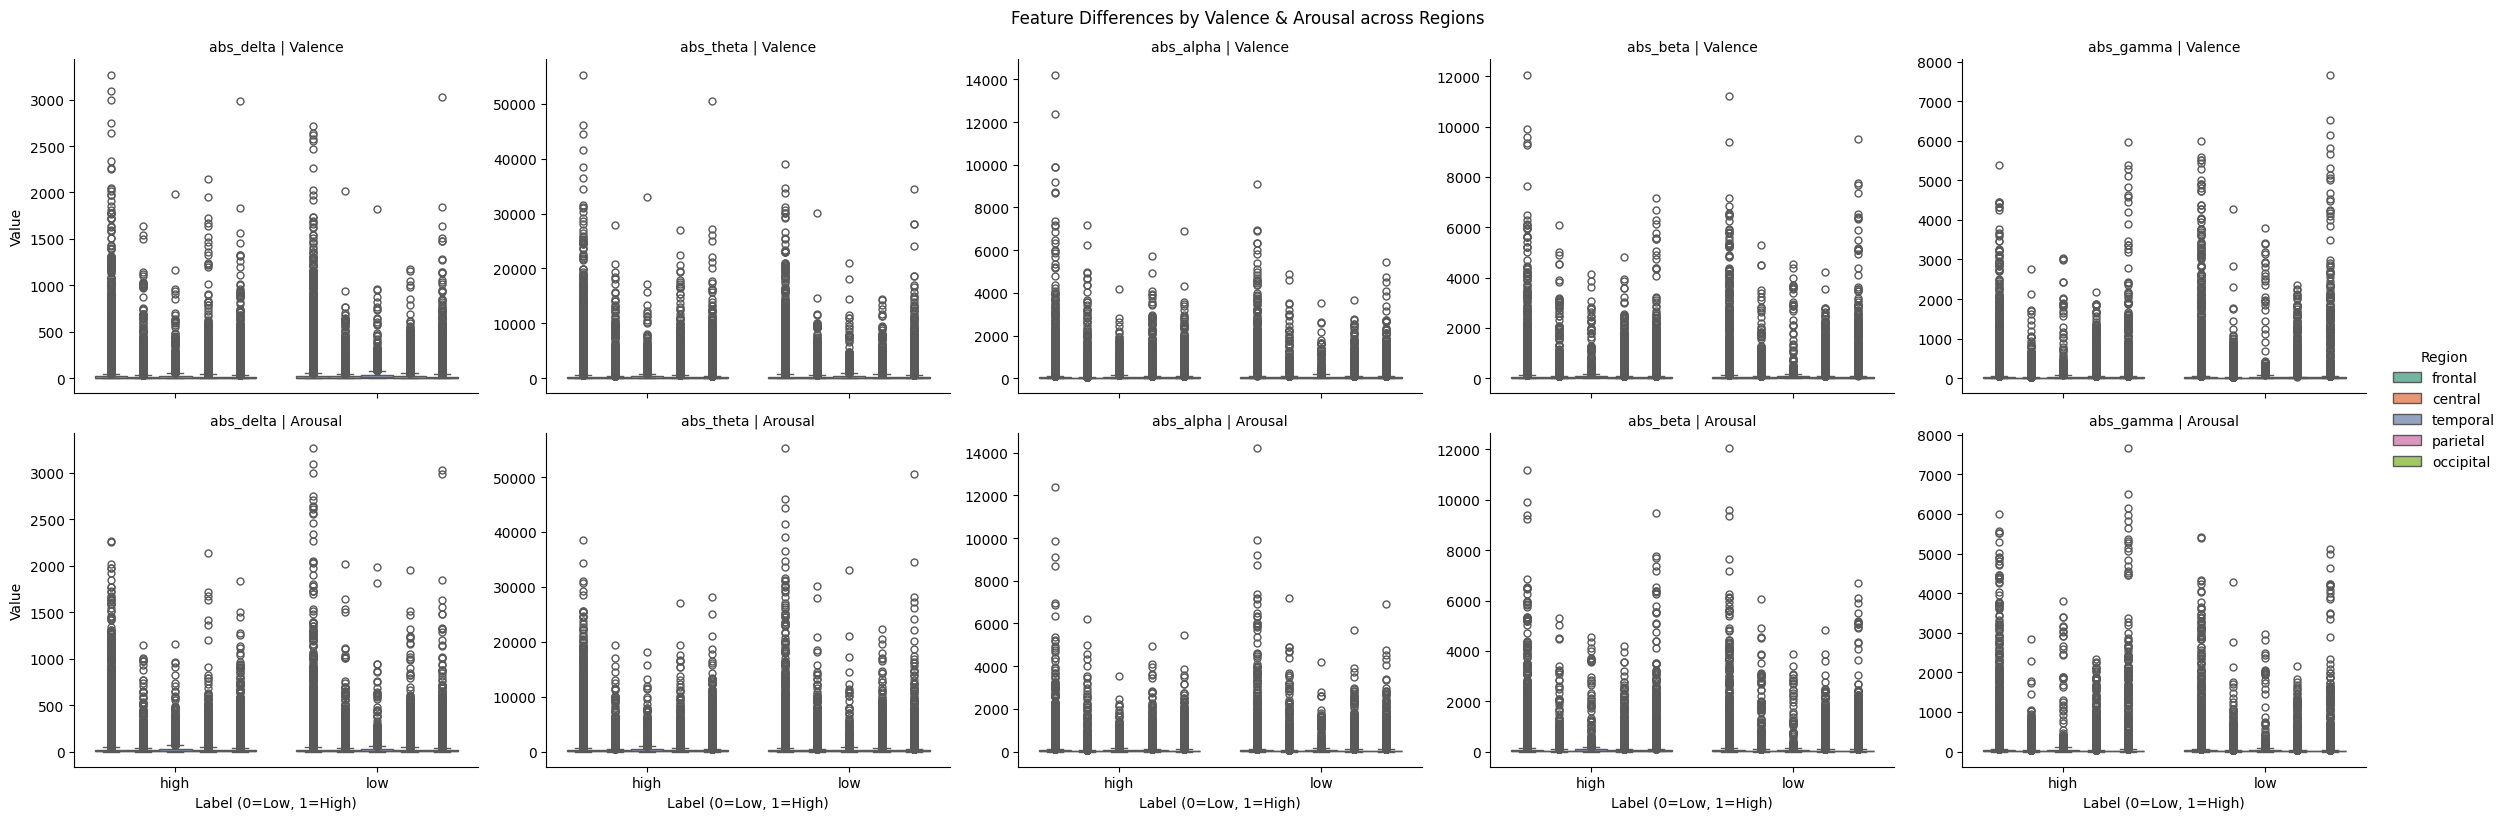

In [21]:
plot_features_valence_arousal(df, ["abs_delta", "abs_theta", "abs_alpha", "abs_beta", "abs_gamma"])

In [28]:
df['abs_alpha'].describe()

count    40960.000000
mean       113.980117
std        388.411290
min          0.843440
25%          9.020917
50%         19.802150
75%         54.757379
max      14229.848545
Name: abs_alpha, dtype: float64

<Axes: >

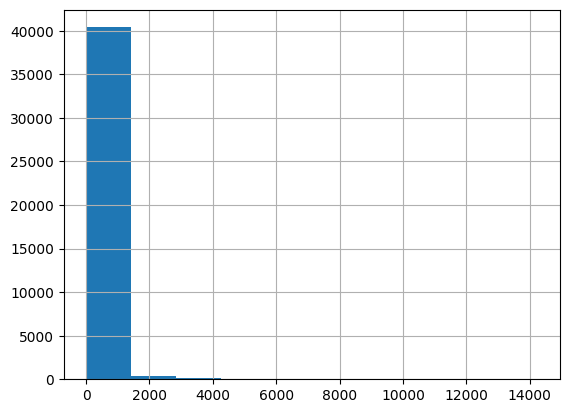

In [29]:
df['abs_alpha'].hist()

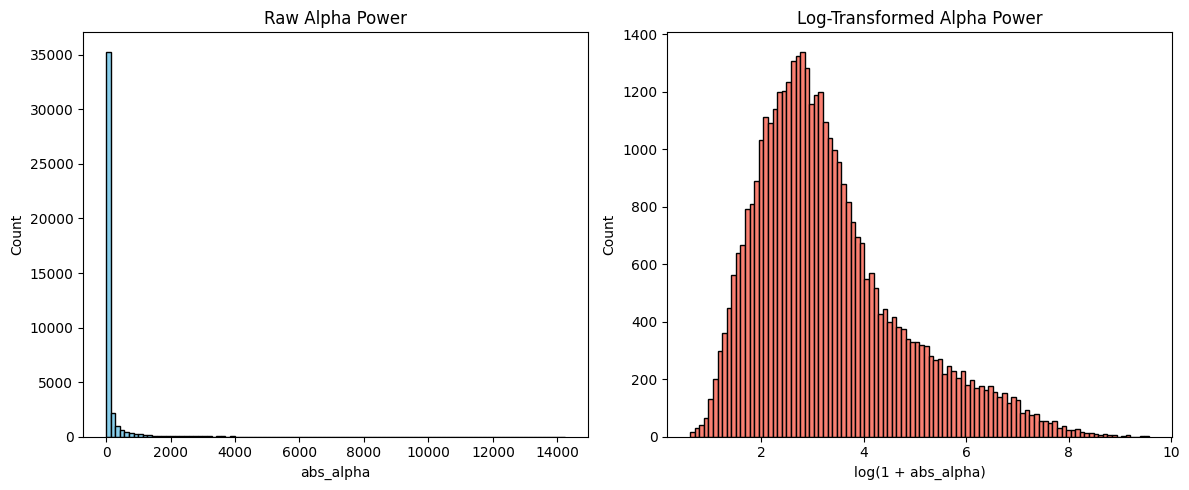

In [34]:
# Log-transform (log(1+x) to avoid log(0))
df["log_abs_alpha"] = np.log1p(df["abs_alpha"])

# Plot raw vs. log-transformed
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw histogram
axes[0].hist(df["abs_alpha"], bins=100, color="skyblue", edgecolor="k")
axes[0].set_title("Raw Alpha Power")
axes[0].set_xlabel("abs_alpha")
axes[0].set_ylabel("Count")

# Log-transformed histogram
axes[1].hist(df["log_abs_alpha"], bins=100, color="salmon", edgecolor="k")
axes[1].set_title("Log-Transformed Alpha Power")
axes[1].set_xlabel("log(1 + abs_alpha)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()